[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 20533
[LightGBM] [Info] Number of data points in the train set: 177371, number of used features: 98
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 70 dense feature groups (12.18 MB) transferred to GPU in 0.013848 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 43.806299
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 131.54	training's l2: 17302.9	valid_1's rmse: 248.757	valid_1's l2: 61879.8
[100]	training's rmse: 108.744	training's l2: 11825.2	valid_1's rmse: 160.514	valid_1's l2: 25764.6
[150]	training's rmse: 99.4955	training's l2: 9899.36	valid_1's rmse: 129.377	valid_1's l2: 16738.4
[200]	training's rmse: 93.7098	training's l2: 

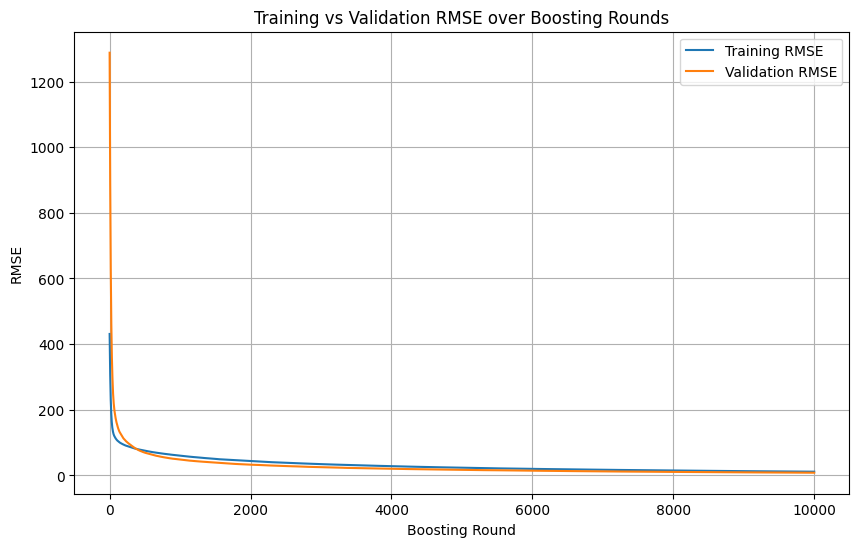

✅ Forecast saved: ./../Data Given for Challenge/results/37_24hr_horizon_recursive_fixed.csv
✅ Forecast saved: ./../Data Given for Challenge/results/37_48hr_horizon_recursive_fixed.csv


In [17]:
# =====================================================
# 0. Imports
# =====================================================
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# =====================================================
# 1. Load and clean data
# =====================================================
df = pd.read_csv("./../Data Given for Challenge/data/normalized_features.csv")
df['ds'] = pd.to_datetime(df['Timestamp'])
df.columns = df.columns.str.strip()
df['Location'] = pd.to_numeric(df['Location'], errors='coerce').astype(int)
df.drop(columns=['Timestamp'], inplace=True)
df.sort_values(['Location','ds'], inplace=True)

# =====================================================
# 2. Add time-based features
# =====================================================
df['hour_of_day'] = df['ds'].dt.hour
df['day_of_week'] = df['ds'].dt.dayofweek

# =====================================================
# 3. Add lag and rolling features
# =====================================================
lags = [1, 24]
rolling_windows = [3, 6]

for lag in lags:
    df[f'lag_{lag}'] = df.groupby('Location')['out'].shift(lag)

for w in rolling_windows:
    df[f'rolling_{w}h'] = df.groupby('Location')['out'].transform(lambda x: x.shift(1).rolling(w).mean())

# Drop initial rows with NaN due to lags/rolling
df.dropna(inplace=True)

# =====================================================
# 4. Train/Validation split
# =====================================================
train = df[df['ds'] < "2023-06-30 01:00:00"]
val   = df[(df['ds'] >= "2023-06-23") & (df['ds'] < "2023-06-30 01:00:00")]

features = [c for c in df.columns if c not in ['ds','Location','out']]
X_train, y_train = train[features], train['out']
X_val, y_val     = val[features], val['out']

# Fixed feature list for prediction
train_features = X_train.columns.tolist()

# =====================================================
# 5. Train LightGBM with GPU
# =====================================================
model = LGBMRegressor(
    n_estimators=10000,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    device='gpu'
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric="rmse",
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=50)]
)

# =====================================================
# 6. Validation RMSE & NRMSE
# =====================================================
train_preds = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_nrmse = train_rmse / (y_train.max() - y_train.min())

val_preds = model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
val_nrmse = val_rmse / (y_val.max() - y_val.min())

print(f"\nTraining RMSE: {train_rmse:.4f}, NRMSE: {train_nrmse:.6f}")
print(f"Validation RMSE: {val_rmse:.4f}, NRMSE: {val_nrmse:.6f}")

# =====================================================
# 7. Plot RMSE over boosting rounds
# =====================================================
evals_result = model.evals_result_
train_rmse_list = evals_result['training']['rmse']
val_rmse_list   = evals_result['valid_1']['rmse']

plt.figure(figsize=(10,6))
plt.plot(train_rmse_list, label='Training RMSE')
plt.plot(val_rmse_list, label='Validation RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.title('Training vs Validation RMSE over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()

# =====================================================
# 8. Fixed recursive forecast function
# =====================================================
def build_forecast_recursive_fixed(model, df, start, end, save_path,
                                   lags=[1,24], rolling_windows=[3,6]):
    """
    Recursive multi-step forecast for LightGBM with lag/rolling features.
    Ensures feature alignment with training data and preserves ds/Location.
    """
    hours = pd.date_range(start=start, end=end, freq="h")
    locations = df['Location'].unique()
    
    forecast_list = []
    df_forecast = df.copy()

    for h in hours:
        hour_rows = []
        for loc in locations:
            row = {'ds': h, 'Location': loc}
            
            # Time features
            row['hour_of_day'] = h.hour
            row['day_of_week'] = h.dayofweek
            
            # Lag features
            for lag in lags:
                lag_time = h - pd.Timedelta(hours=lag)
                lag_value = df_forecast[(df_forecast['Location']==loc) & (df_forecast['ds']==lag_time)]['out']
                row[f'lag_{lag}'] = lag_value.values[0] if not lag_value.empty else 0.0
            
            # Rolling features
            for w in rolling_windows:
                past_hours = df_forecast[(df_forecast['Location']==loc) & (df_forecast['ds'] < h)].sort_values('ds').tail(w)
                row[f'rolling_{w}h'] = past_hours['out'].mean() if not past_hours.empty else 0.0
            
            # Static features
            last_static = df_forecast[df_forecast['Location']==loc].iloc[-1]
            for f in train_features:
                if f not in row:
                    row[f] = last_static[f]
            
            hour_rows.append(row)
        
        # Build DataFrame for this hour
        hour_df = pd.DataFrame(hour_rows)
        
        # Preserve ds and Location before reindexing
        ds_values = hour_df['ds'].copy()
        loc_values = hour_df['Location'].copy()

        # Ensure exact feature alignment and order with training
        hour_df = hour_df.reindex(columns=train_features, fill_value=0)

        # Predict
        hour_df['pred'] = model.predict(hour_df)

        # Add predictions as 'out' for next iteration
        hour_df['out'] = hour_df['pred']
        hour_df['ds'] = ds_values
        hour_df['Location'] = loc_values

        # Update forecast dataframe
        df_forecast = pd.concat([df_forecast, hour_df], ignore_index=True)

        # Append to forecast list
        forecast_list.append(hour_df[['ds','Location','pred']])
    
    # Combine forecast and save
    forecast_df = pd.concat(forecast_list).reset_index(drop=True)
    forecast_df.rename(columns={'ds':'timestamp','Location':'location'}, inplace=True)
    forecast_df.to_csv(save_path, index=False)
    print(f"✅ Forecast saved: {save_path}")
    
    return forecast_df

# =====================================================
# 9. Generate 24h and 48h forecasts
# =====================================================
start_24h = pd.Timestamp("2023-06-30 01:00:00")
end_24h   = start_24h + pd.Timedelta(hours=23)
start_48h = pd.Timestamp("2023-06-30 01:00:00")
end_48h   = start_48h + pd.Timedelta(hours=47)

output_24h = build_forecast_recursive_fixed(
    model, df, start_24h, end_24h,
    save_path="./../Data Given for Challenge/results/37_24hr_horizon_recursive_fixed.csv",
    lags=lags, rolling_windows=rolling_windows
)

output_48h = build_forecast_recursive_fixed(
    model, df, start_48h, end_48h,
    save_path="./../Data Given for Challenge/results/37_48hr_horizon_recursive_fixed.csv",
    lags=lags, rolling_windows=rolling_windows
)
